In [1]:
!pip install quantecon

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe

In [3]:
class SmoothingExample:
    """
    Class for constructing, solving, and plotting results for
    inventories and sales smoothing problem.
    """

    def __init__(self,
                 β=0.96,           # Discount factor
                 c1=1,             # Cost-of-production
                 c2=1,
                 d1=1,             # Cost-of-holding inventories
                 d2=1,
                 a0=10,            # Inverse demand function
                 a1=1,
                 A22=[[1,   0],    # z process
                      [1, 0.9]],
                 C2=[[0], [1]],
                 G=[0, 1]):

        self.β = β
        self.c1, self.c2 = c1, c2
        self.d1, self.d2 = d1, d2
        self.a0, self.a1 = a0, a1
        self.A22 = np.atleast_2d(A22)
        self.C2 = np.atleast_2d(C2)
        self.G = np.atleast_2d(G)

        # Dimensions
        k, j = self.C2.shape        # Dimensions for randomness part
        n = k + 1                   # Number of states
        m = 2                       # Number of controls

        Sc = np.zeros(k)
        Sc[0] = 1

        # Construct matrices of transition law
        A = np.zeros((n, n))
        A[0, 0] = 1
        A[1:, 1:] = self.A22

        B = np.zeros((n, m))
        B[0, :] = 1, -1

        C = np.zeros((n, j))
        C[1:, :] = self.C2

        self.A, self.B, self.C = A, B, C

        # Construct matrices of one period profit function
        R = np.zeros((n, n))
        R[0, 0] = d2
        R[1:, 0] = d1 / 2 * Sc
        R[0, 1:] = d1 / 2 * Sc

        Q = np.zeros((m, m))
        Q[0, 0] = c2
        Q[1, 1] = a1 + d2

        N = np.zeros((m, n))
        N[1, 0] = - d2
        N[0, 1:] = c1 / 2 * Sc
        N[1, 1:] = - a0 / 2 * Sc - self.G / 2

        self.R, self.Q, self.N = R, Q, N

        # Construct LQ instance
        self.LQ = qe.LQ(Q, R, A, B, C, N, beta=β)
        self.LQ.stationary_values()

    def simulate(self, x0, T=100):

        c1, c2 = self.c1, self.c2
        d1, d2 = self.d1, self.d2
        a0, a1 = self.a0, self.a1
        G = self.G

        x_path, u_path, w_path = self.LQ.compute_sequence(x0, ts_length=T)

        I_path = x_path[0, :-1]
        z_path = x_path[1:, :-1]
        𝜈_path = (G @ z_path)[0, :]

        Q_path = u_path[0, :]
        S_path = u_path[1, :]

        revenue = (a0 - a1 * S_path + 𝜈_path) * S_path
        cost_production = c1 * Q_path + c2 * Q_path ** 2
        cost_inventories = d1 * I_path + d2 * (S_path - I_path) ** 2

        Q_no_inventory = (a0 + 𝜈_path - c1) / (2 * (a1 + c2))
        Q_hardwired = (a0 + 𝜈_path - c1) / (2 * (a1 + c2 + d2))

        fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        ax[0, 0].plot(range(T), I_path, label="inventories")
        ax[0, 0].plot(range(T), S_path, label="sales")
        ax[0, 0].plot(range(T), Q_path, label="production")
        ax[0, 0].legend(loc=1)
        ax[0, 0].set_title("inventories, sales, and production")

        ax[0, 1].plot(range(T), (Q_path - S_path), color='b')
        ax[0, 1].set_ylabel("change in inventories", color='b')
        span = max(abs(Q_path - S_path))
        ax[0, 1].set_ylim(0-span*1.1, 0+span*1.1)
        ax[0, 1].set_title("demand shock and change in inventories")

        ax1_ = ax[0, 1].twinx()
        ax1_.plot(range(T), 𝜈_path, color='r')
        ax1_.set_ylabel("demand shock", color='r')
        span = max(abs(𝜈_path))
        ax1_.set_ylim(0-span*1.1, 0+span*1.1)

        ax1_.plot([0, T], [0, 0], '--', color='k')

        ax[1, 0].plot(range(T), revenue, label="revenue")
        ax[1, 0].plot(range(T), cost_production, label="cost_production")
        ax[1, 0].plot(range(T), cost_inventories, label="cost_inventories")
        ax[1, 0].legend(loc=1)
        ax[1, 0].set_title("profits decomposition")

        ax[1, 1].plot(range(T), Q_path, label="production")
        ax[1, 1].plot(range(T), Q_hardwired, label='production when  $I_t$ \
            forced to be zero')
        ax[1, 1].plot(range(T), Q_no_inventory, label='production when \
            inventories not useful')
        ax[1, 1].legend(loc=1)
        ax[1, 1].set_title('three production concepts')

        plt.show()

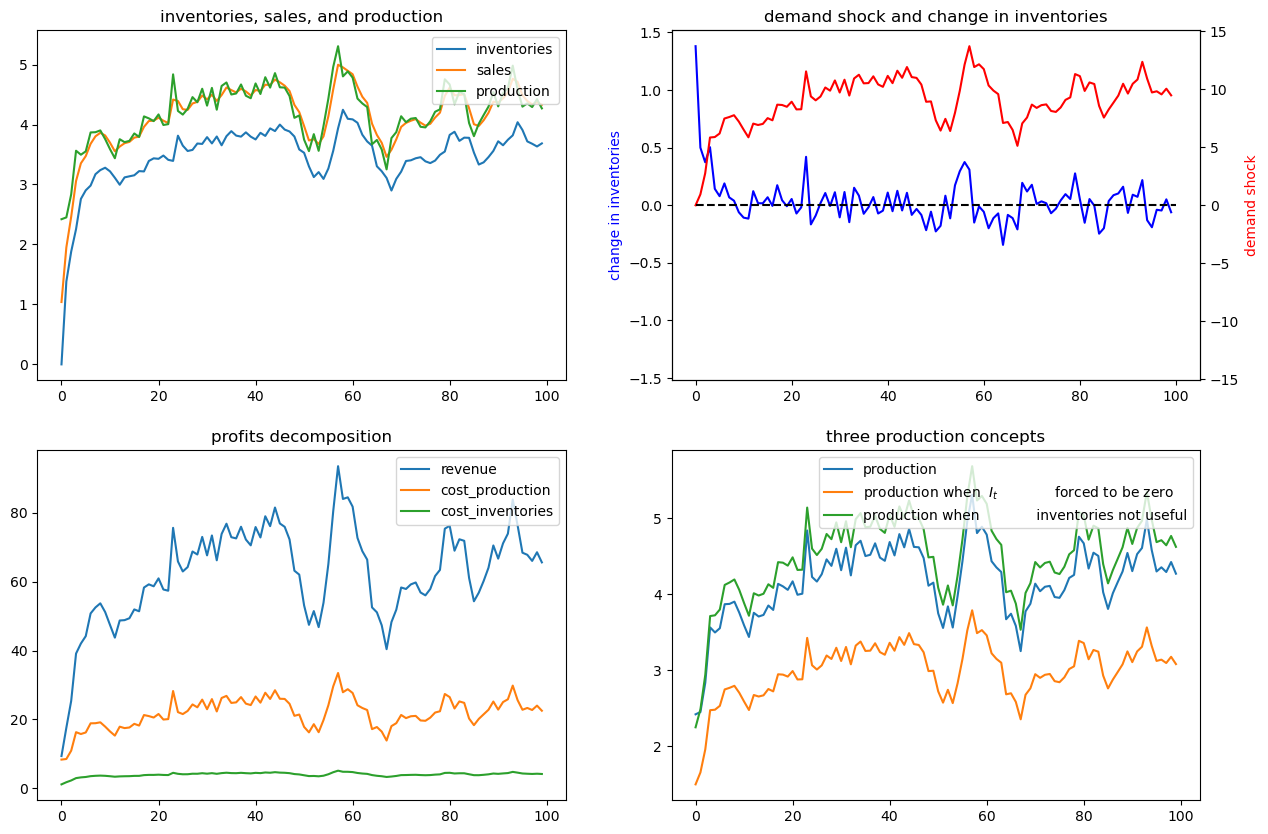

In [4]:
ex1 = SmoothingExample()

x0 = [0, 1, 0]
ex1.simulate(x0)

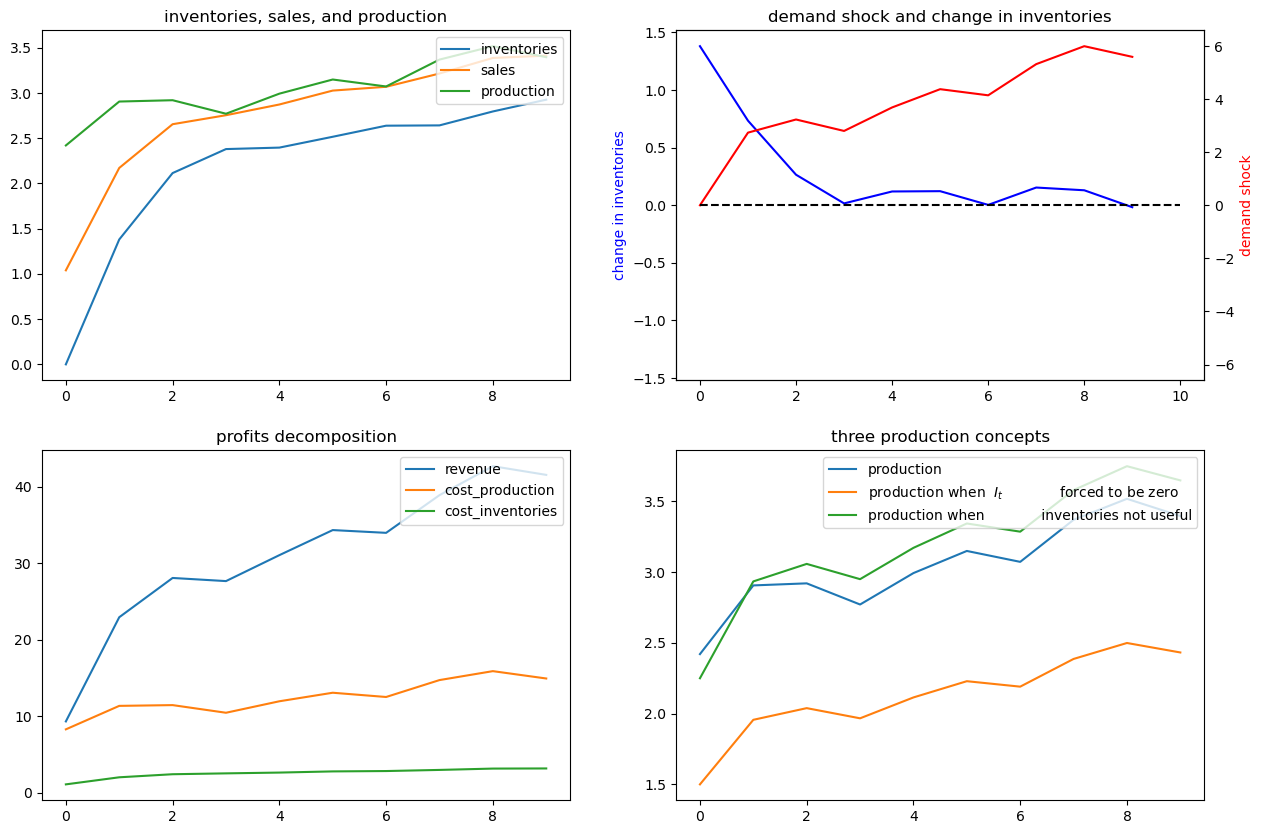

In [5]:
ex1.simulate(x0, T=10)

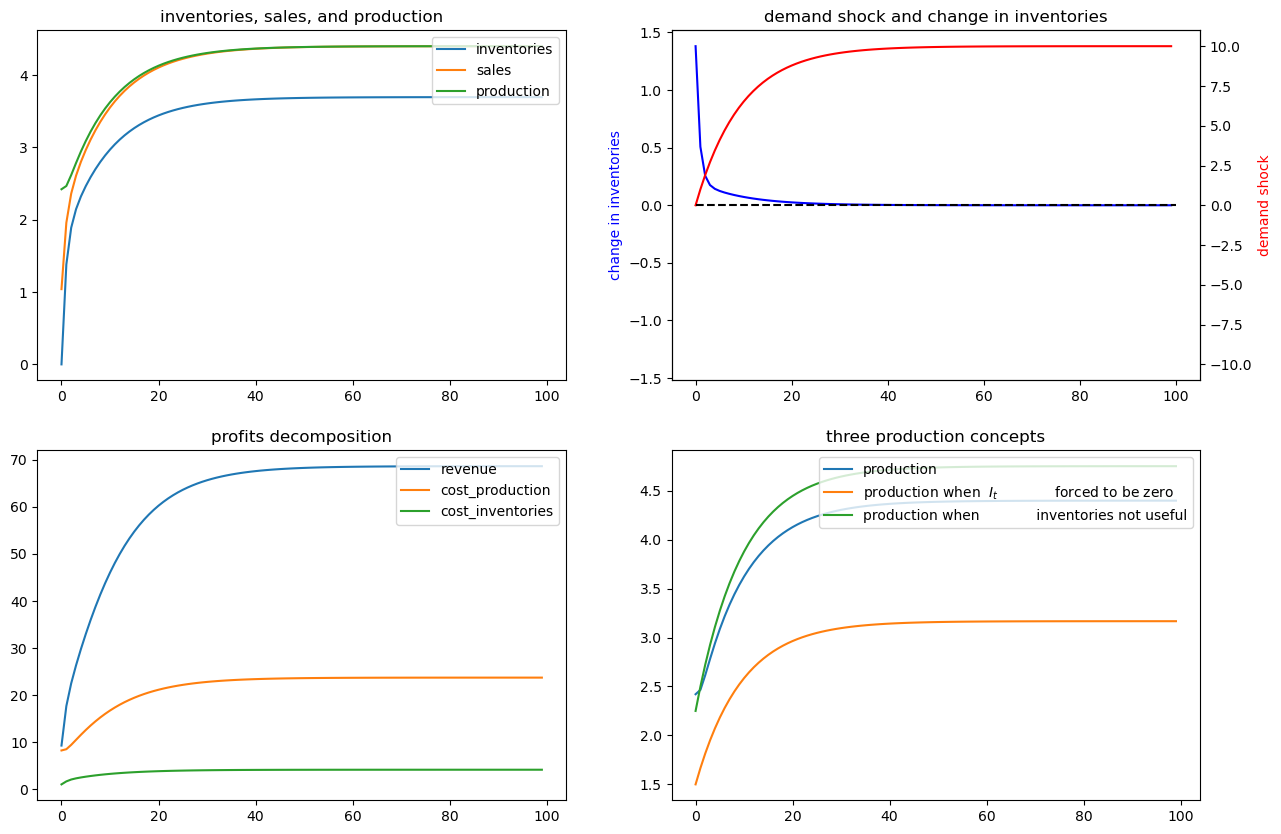

In [6]:
ex2 = SmoothingExample(C2=[[0], [0]])

x0 = [0, 1, 0]
ex2.simulate(x0)

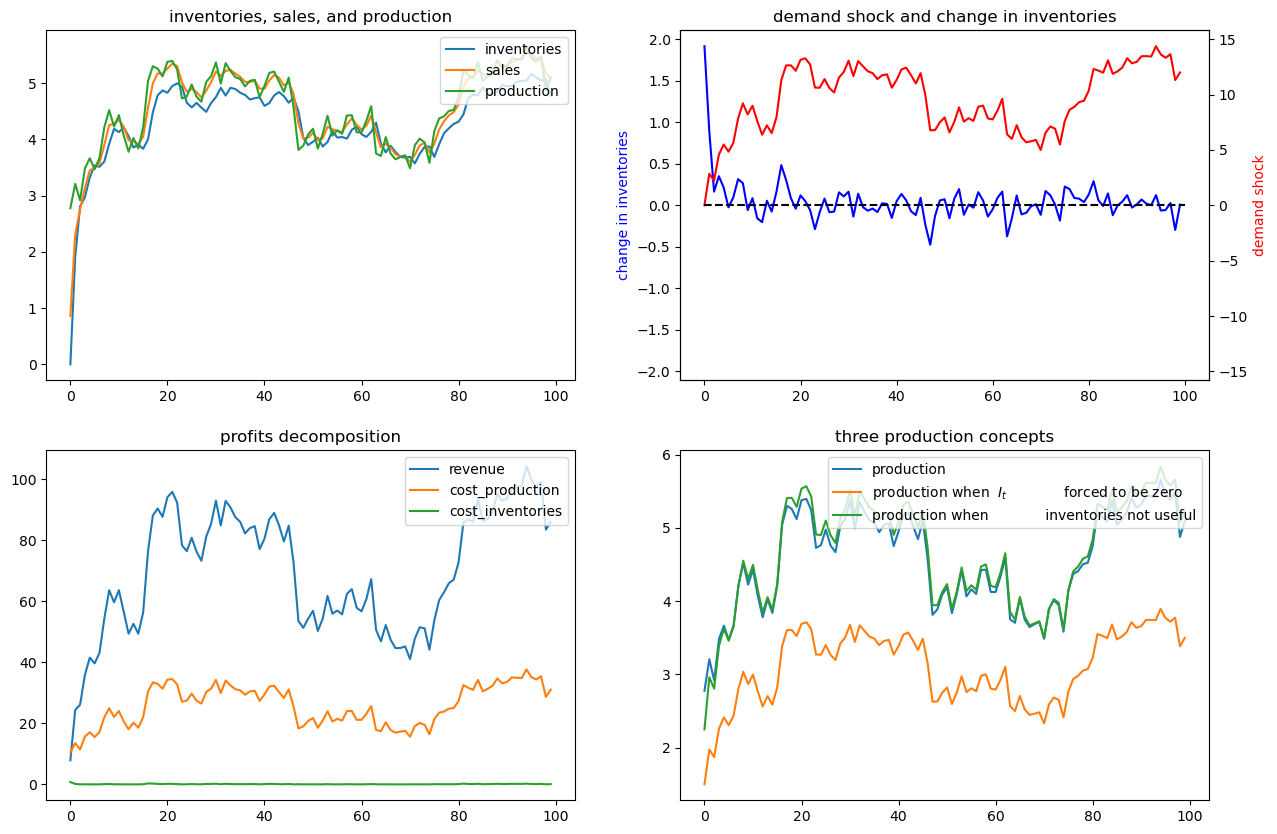

In [7]:
ex3 = SmoothingExample(d1=0)

x0 = [0, 1, 0]
ex3.simulate(x0)

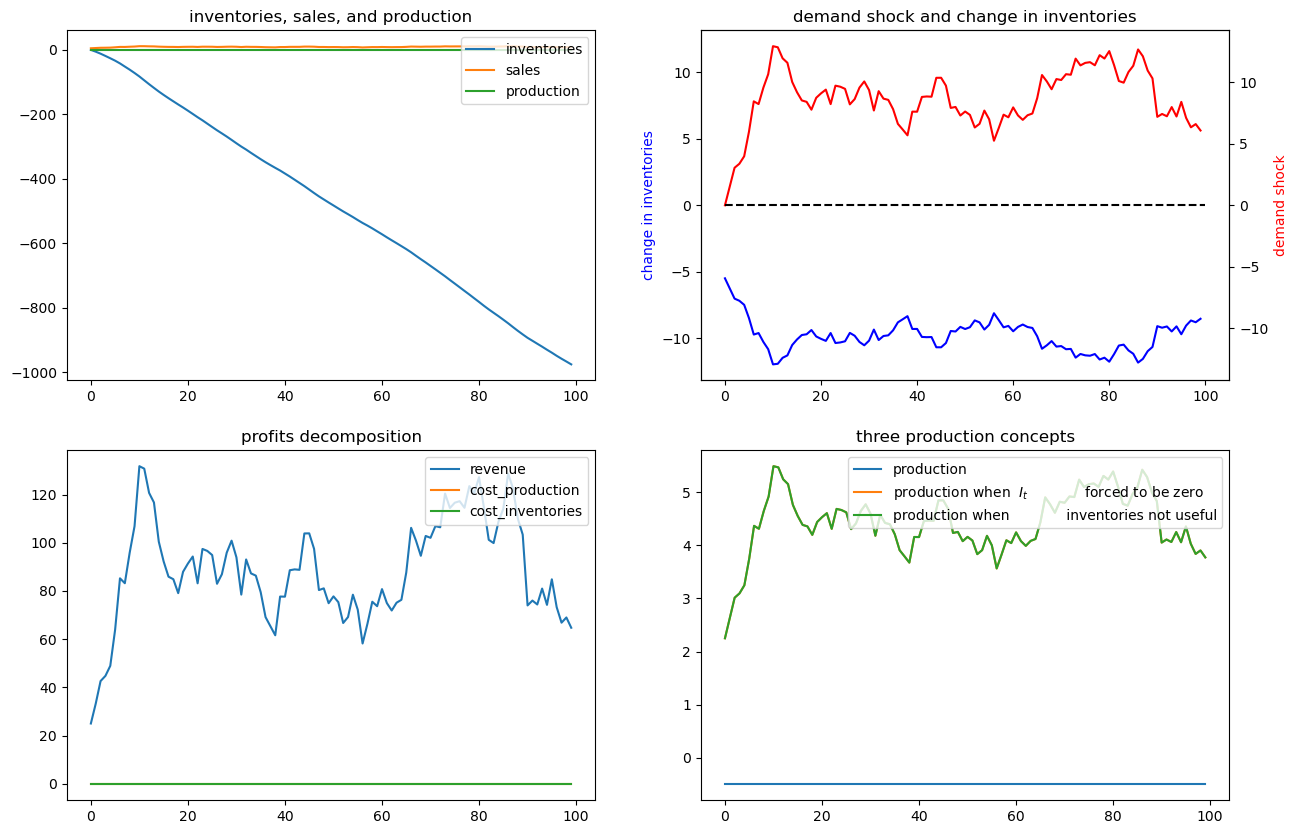

In [8]:
ex4 = SmoothingExample(d1=0, d2=0)

x0 = [0, 1, 0]
ex4.simulate(x0)

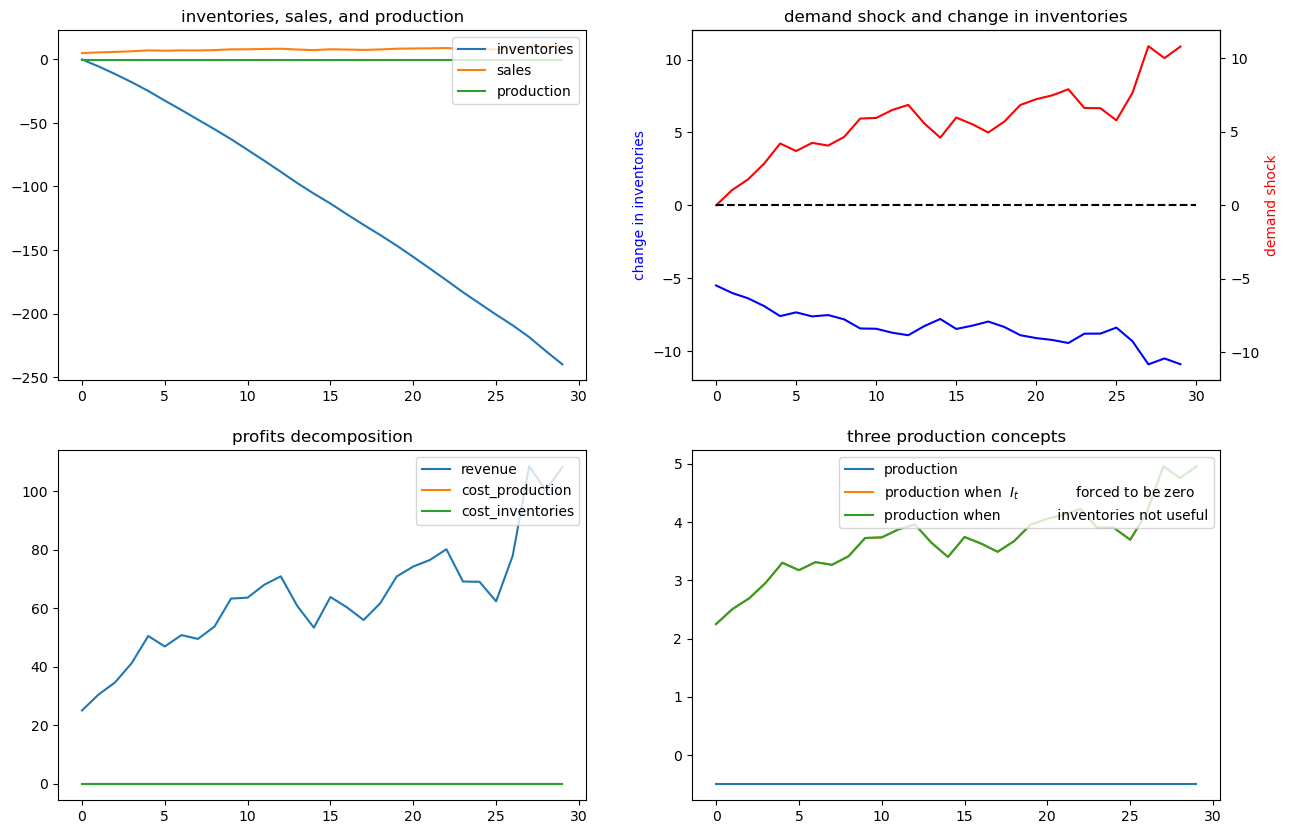

In [9]:
# shorter period
ex4.simulate(x0, T=30)

In [10]:
# Set parameters
a = 0.5
b = 3.

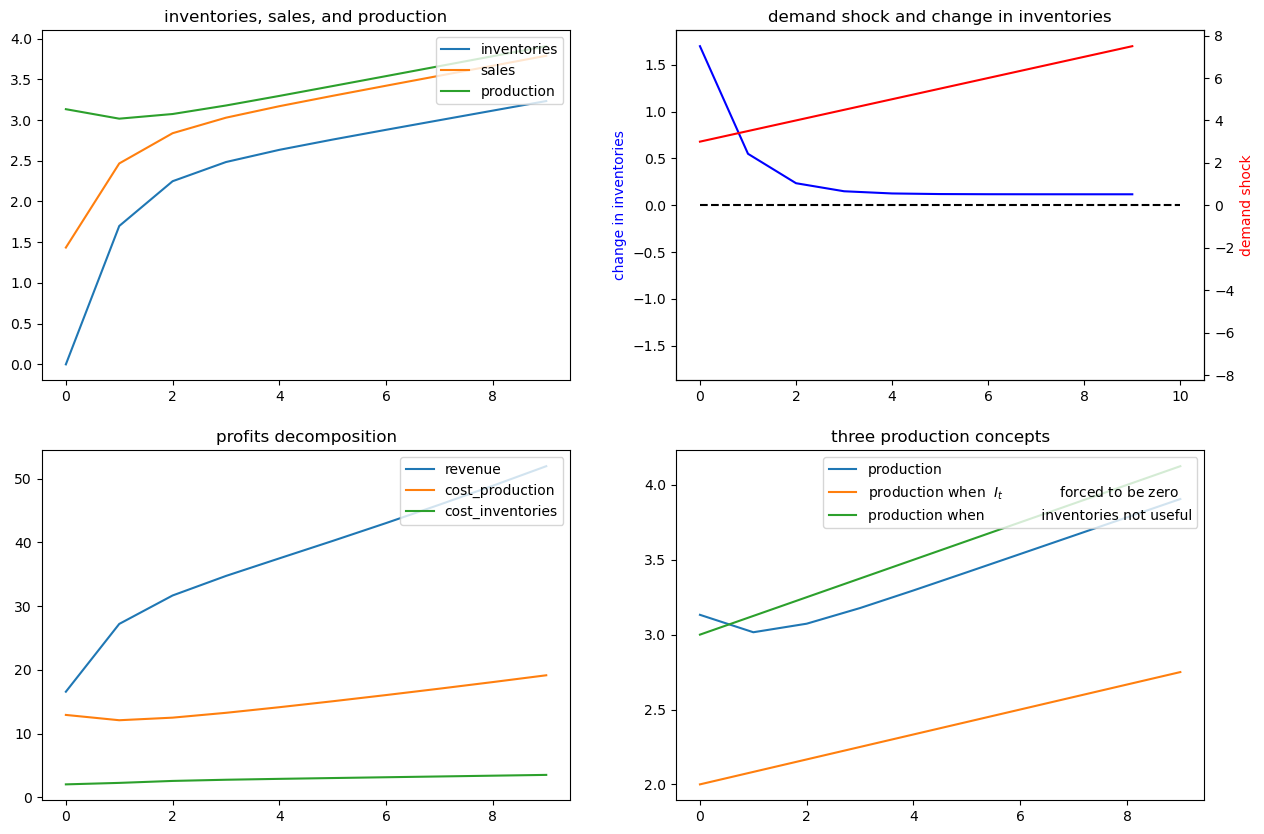

In [11]:
ex5 = SmoothingExample(A22=[[1, 0], [1, 1]], C2=[[0], [0]], G=[b, a])

x0 = [0, 1, 0] # set the initial inventory as 0
ex5.simulate(x0, T=10)

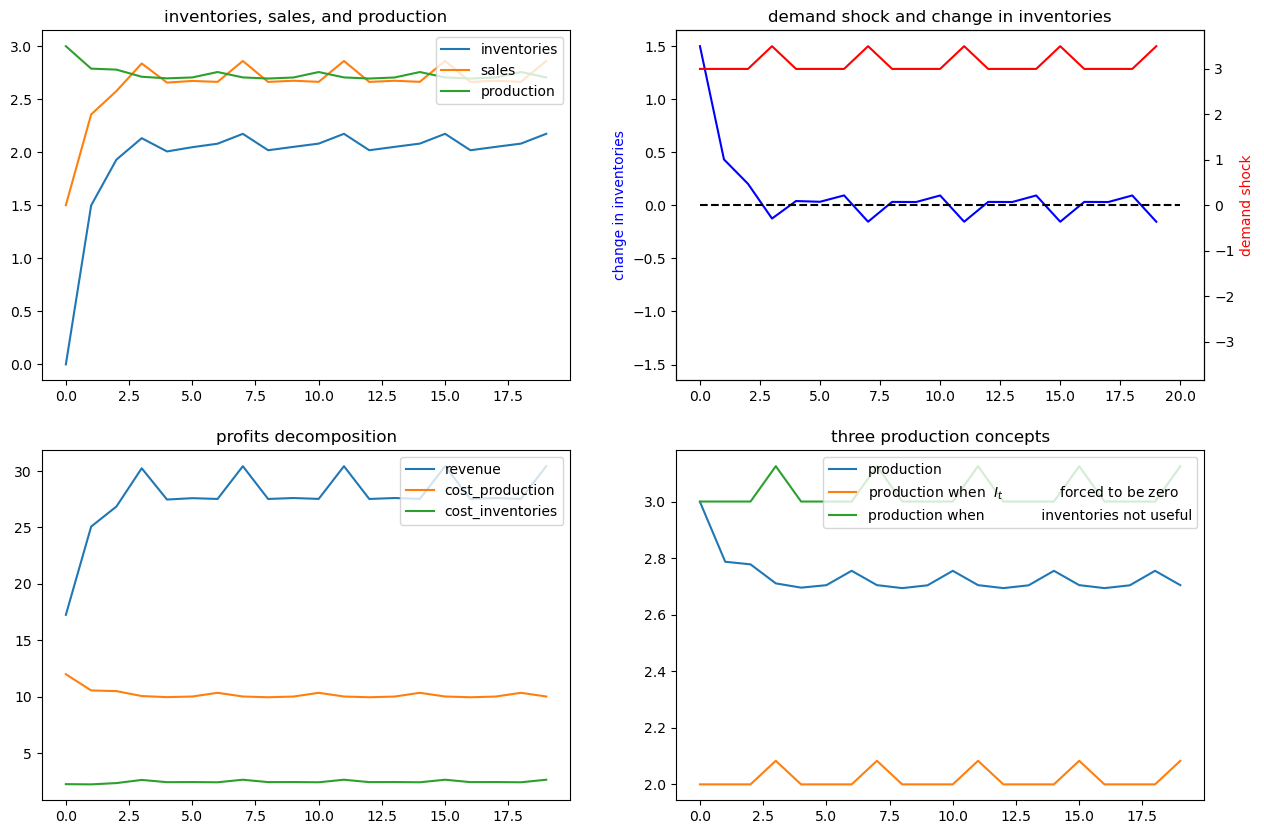

In [12]:
ex6 = SmoothingExample(A22=[[1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 1, 0, 0, 0],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 1, 0]],
                       C2=[[0], [0], [0], [0], [0]],
                       G=[b, a, 0, 0, 0])

x00 = [0, 1, 0, 1, 0, 0] # Set the initial inventory as 0
ex6.simulate(x00, T=20)

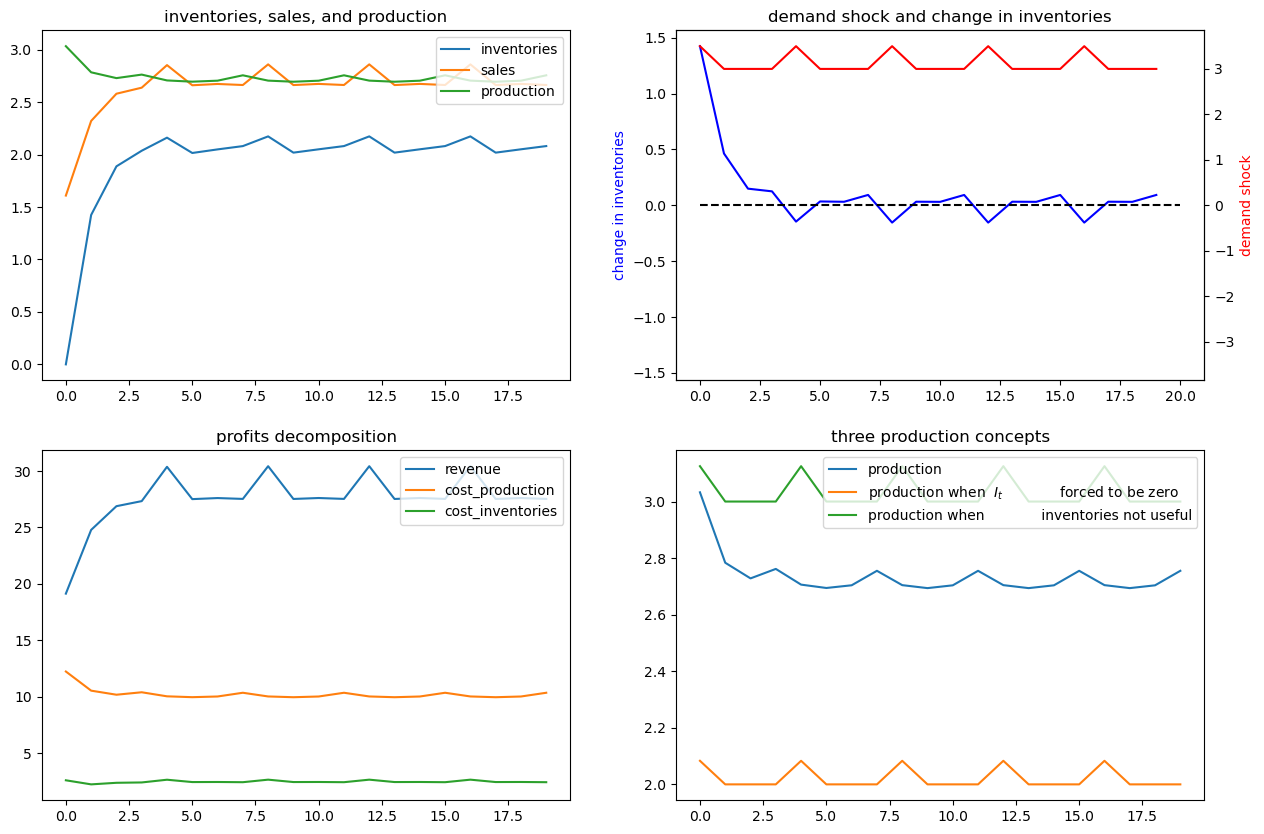

In [13]:
x01 = [0, 1, 1, 0, 0, 0]
ex6.simulate(x01, T=20)

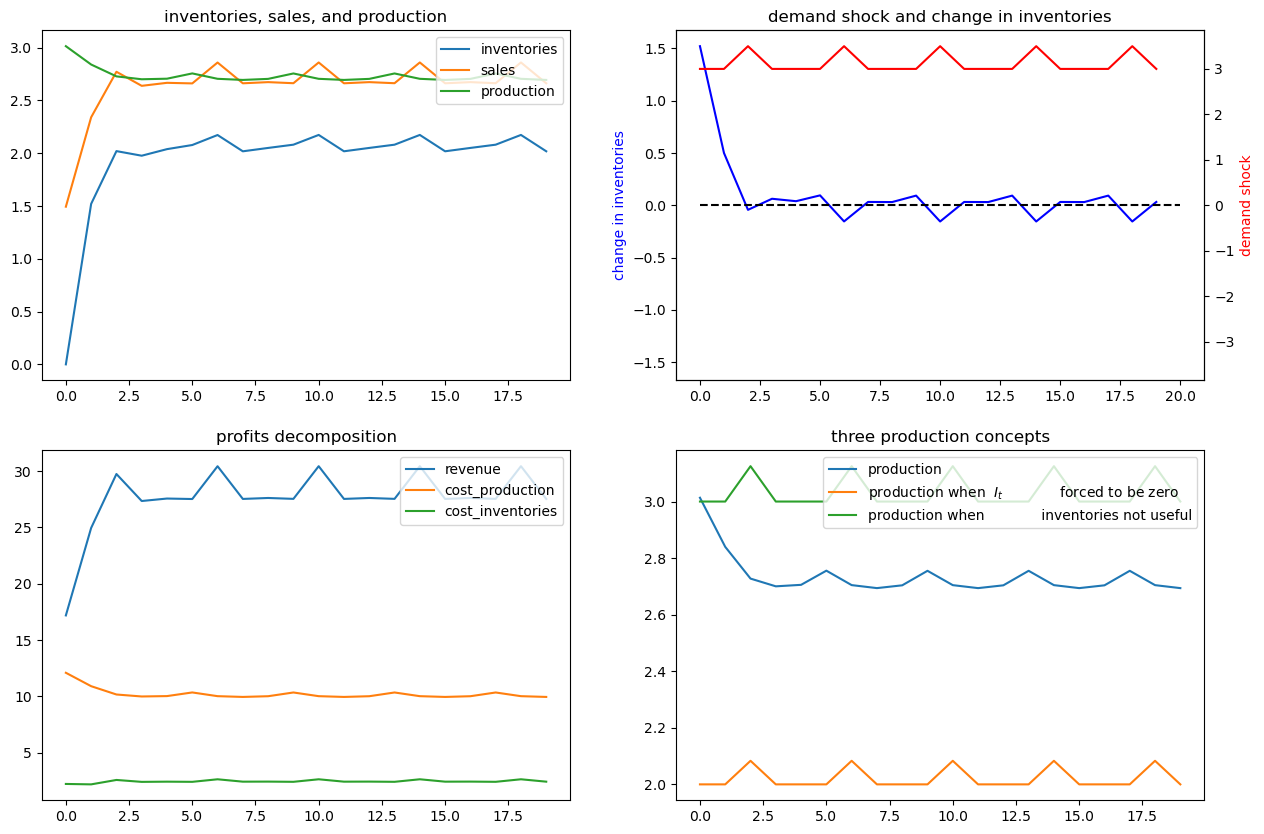

In [14]:
x02 = [0, 1, 0, 0, 1, 0]
ex6.simulate(x02, T=20)

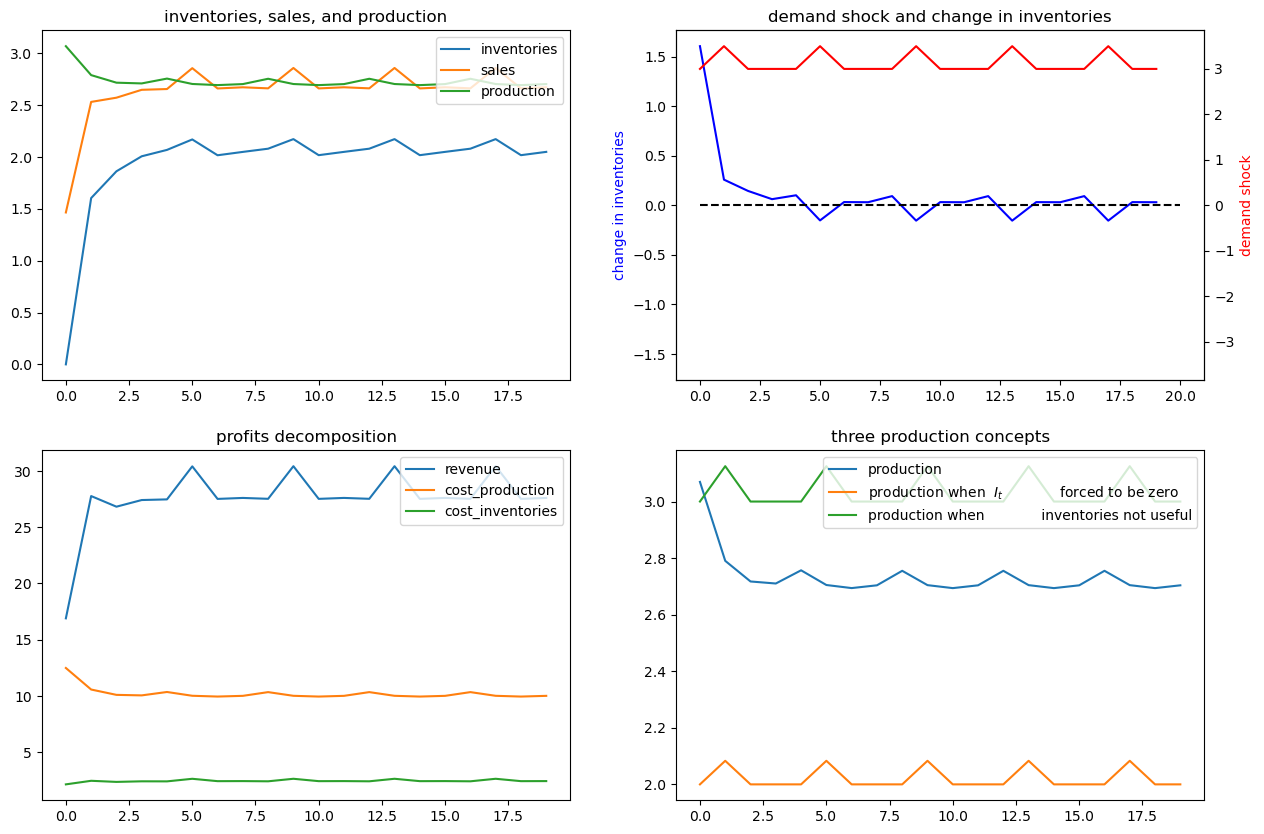

In [15]:
x03 = [0, 1, 0, 0, 0, 1]
ex6.simulate(x03, T=20)

In [16]:
# set parameters
α = 1
ρ1 = 1.2
ρ2 = -.3

In [17]:
# construct matrices
A22 =[[1,  0,  0],
          [1, ρ1, ρ2],
          [0,  1, 0]]
C2 = [[0], [1], [0]]
G = [0, 1, 0]

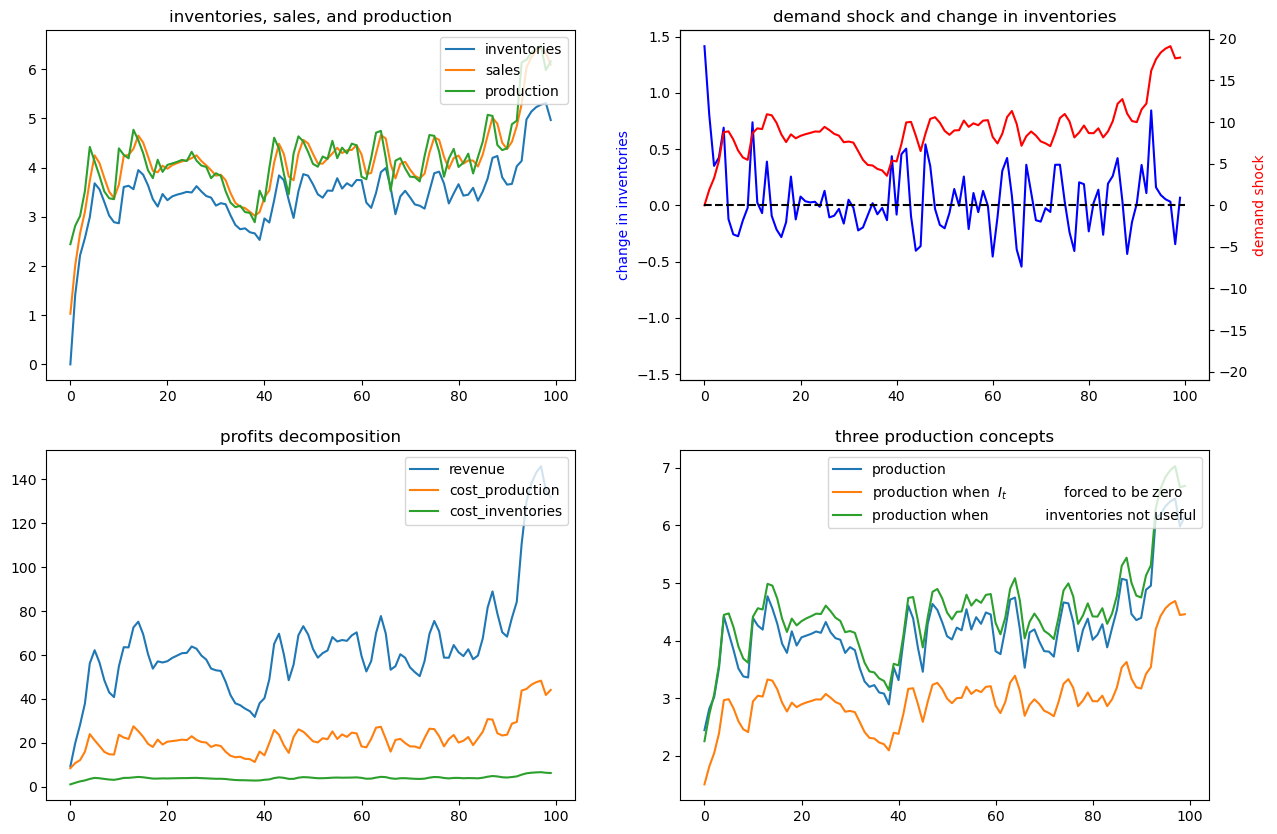

In [18]:
ex1 = SmoothingExample(A22=A22, C2=C2, G=G)

x0 = [0, 1, 0, 0] # initial condition
ex1.simulate(x0)

In [19]:
# now silence the noise
ex1_no_noise = SmoothingExample(A22=A22, C2=[[0], [0], [0]], G=G)

# initial condition
x0 = [0, 1, 0, 0]

# compute stationary states
x_bar = ex1_no_noise.LQ.compute_sequence(x0, ts_length=250)[0][:, -1]
x_bar

array([ 3.69387755,  1.        , 10.        , 10.        ])

In [20]:
T = 40

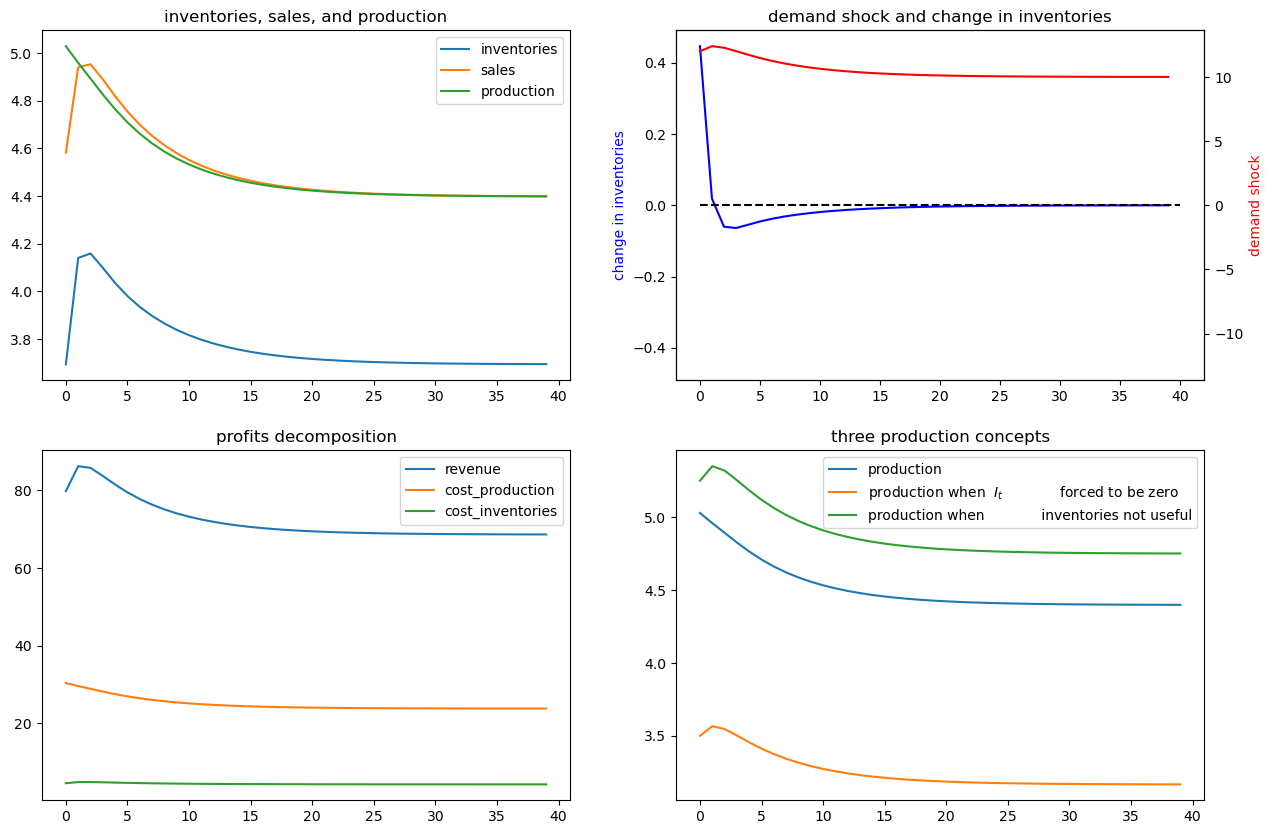

In [21]:
# small shock
x_bar1 = x_bar.copy()
x_bar1[2] += 2
ex1_no_noise.simulate(x_bar1, T=T)

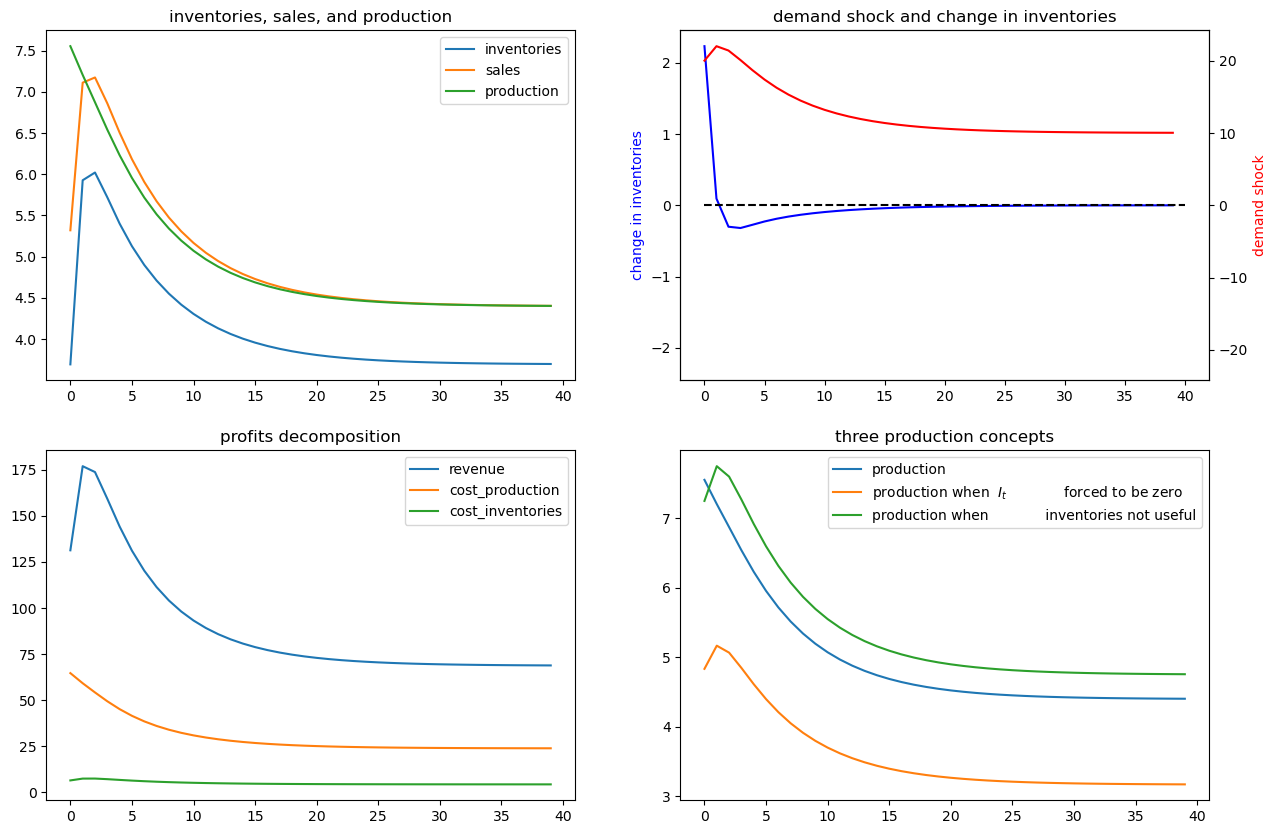

In [22]:
# large shock
x_bar1 = x_bar.copy()
x_bar1[2] += 10
ex1_no_noise.simulate(x_bar1, T=T)

In [23]:
x0 = [0, 1, 0]

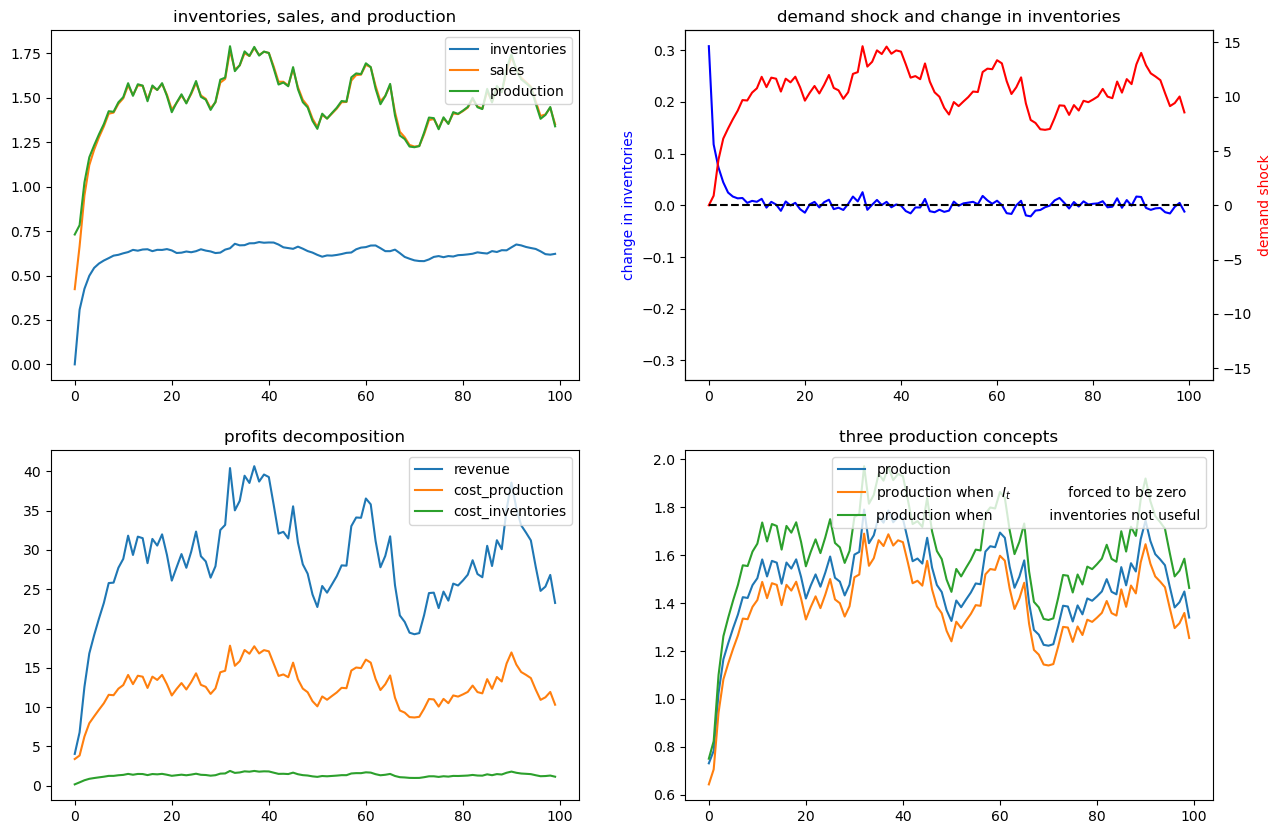

In [24]:
SmoothingExample(c2=5).simulate(x0)

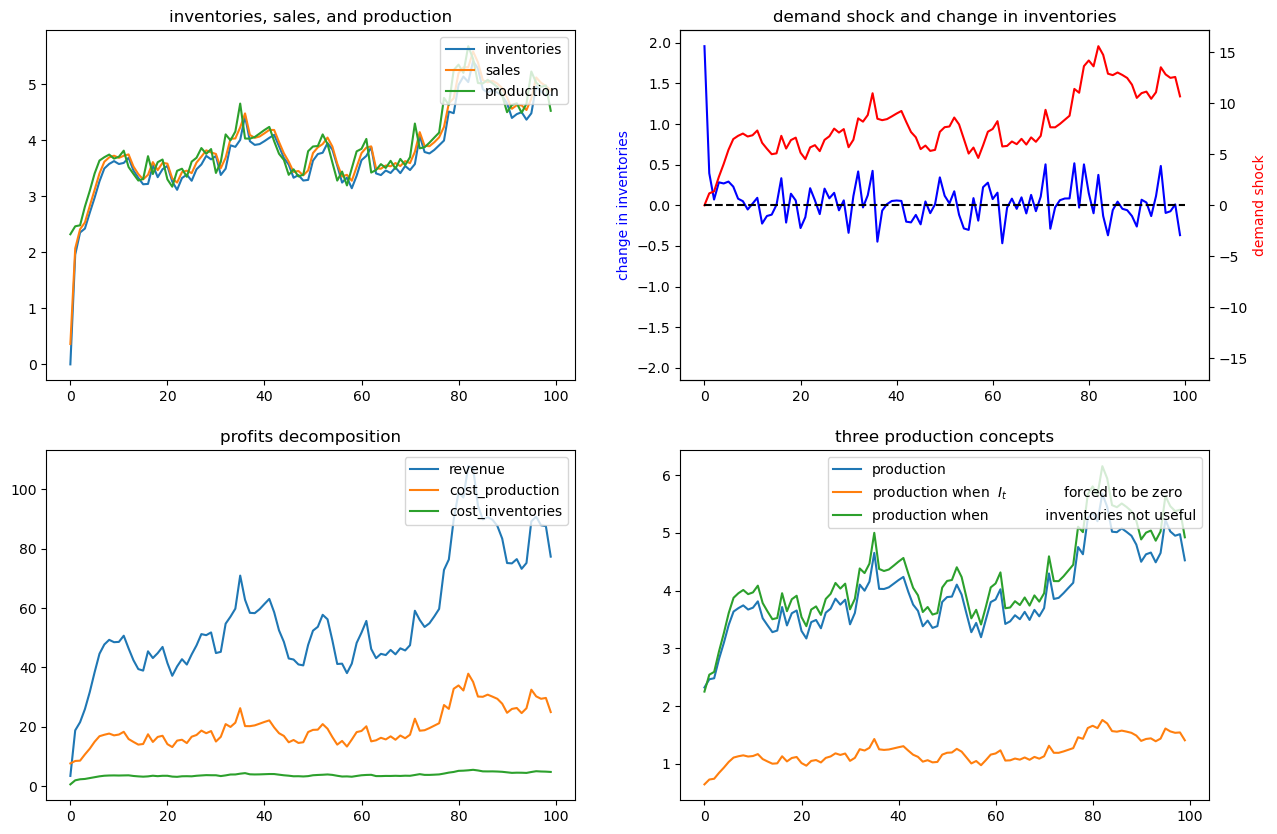

In [25]:
SmoothingExample(d2=5).simulate(x0)